### Uso de Múltiples Agentes con LangGraph  
#### Desafíos de los Sistemas de Agente Único

Los sistemas basados en un solo agente suelen ser ineficientes cuando se trata de abordar tareas diversas o ejecutar aplicaciones que requieren múltiples herramientas. Imagina, por ejemplo, el tamaño del contexto si un solo modelo tuviera que manejar cientos de herramientas, cada una con su propia descripción, esquema de entrada/salida y lógica de uso. Esto puede volver el procesamiento poco práctico y propenso a errores.

Algunos de los desafíos más comunes de los sistemas de agente único incluyen:

- **Falta de flexibilidad**: la aplicación depende de un único modelo de lenguaje (LLM), lo que limita su capacidad de adaptación.
- **Sobrecarga de contexto**: demasiada información debe procesarse simultáneamente en un solo agente.
- **Procesamiento secuencial**: no hay paralelismo, lo que reduce la eficiencia.
- **Punto único de fallo**: si el único agente falla, todo el sistema se ve comprometido.

---

### ¿Qué abordaremos en este laboratorio?

En este laboratorio, exploraremos soluciones a estos problemas mediante:

- Colaboración entre múltiples agentes.
- Uso de memoria para conversaciones por turnos.
- Integración de herramientas como APIs y RAG (Retrieval-Augmented Generation) para mejorar la búsqueda de respuestas.
- Inclusión de humanos en el bucle para decisiones críticas.

---

### Sistemas de Múltiples Agentes

En una arquitectura de múltiples agentes, cada agente puede estar diseñado con su propio prompt, modelo de lenguaje y herramientas específicas. Este enfoque permite distribuir la carga de trabajo y especializar a los agentes según su función.

**Ventajas clave de los sistemas multi-agente:**

- Mayor eficiencia al asignar tareas específicas a agentes especializados.
- Agrupación lógica de herramientas que mejora la coherencia y relevancia de los resultados.
- Facilita la gestión de prompts al estar segmentados por agente.
- Permite pruebas, evaluación y mantenimiento independientes de cada componente.

---

### Patrón de Supervisión: Coordinación Centralizada

En este laboratorio, utilizaremos el **patrón de agente supervisor**. En este esquema, múltiples agentes especializados están conectados a través de un agente supervisor. Las interacciones fluyen por medio de este agente central, pero cada agente mantiene su propio contexto o "scratchpad".

**El rol del agente supervisor:**

- Coordina las acciones entre agentes especializados.
- Asigna tareas según las capacidades de cada agente y los requerimientos del flujo.
- Facilita el paralelismo y reduce la sobrecarga contextual.
- Mejora la flexibilidad y escalabilidad del sistema.
- Minimiza riesgos al distribuir las responsabilidades entre varios agentes.

---

### Escenario de Ejemplo: Asistente de Viajes

La siguiente imagen (no incluida aquí) ilustra el flujo de datos y control en nuestro sistema de Asistente de Viajes.

---

### Agente de Vuelos

El **agente de vuelos** está especializado en gestionar tareas relacionadas con la reserva y modificación de vuelos. Utiliza herramientas específicas para:

- Buscar vuelos disponibles.
- Recuperar detalles de reservas existentes.
- Modificar o cancelar reservas de vuelo.

**Herramientas del agente de vuelos:**

1. **Herramienta de Búsqueda de Vuelos**  
   Permite buscar vuelos entre dos ciudades en una fecha determinada. Proporciona datos sobre aerolíneas, horarios de salida/llegada, duración y precios estimados.

2. **Herramienta de Recuperación de Reservas**  
   Permite acceder a la información detallada de una reserva utilizando un identificador. Es útil para confirmar detalles antes del viaje.

3. **Herramienta de Modificación de Reservas**  
   Ofrece la opción de cambiar la fecha, la hora o cancelar reservas existentes según las necesidades del usuario.

4. **Herramienta de Cancelación**  
   Facilita la cancelación directa de una reserva, simplificando la gestión de itinerarios.

---

### Herramienta de Búsqueda de Vuelos – `search_flights`

La función `search_flights` simula un motor de búsqueda de vuelos entre dos ciudades, en una fecha determinada.

- **Propósito**: generar datos ficticios para representar una búsqueda de vuelos, útil para pruebas y desarrollo de sistemas sin depender de APIs reales.
- **Importante**: esta herramienta no accede a información real, sino que genera datos aleatorios con fines demostrativos.



In [1]:

import sqlite3
from contextlib import closing

In [2]:
# Importaciones necesarias para herramientas, generación de datos, manejo de fechas y estructuras de datos
from langchain_core.tools import tool  # Decorador para definir herramientas compatibles con LangChain
import random  # Para generar datos simulados
from datetime import datetime, timedelta  # Para manipulación de fechas
from langgraph.prebuilt import ToolNode  # No se usa en este script directamente
import sqlite3  # No se utiliza, se puede eliminar si no se planea usar
import pandas as pd  # Para manejar estructuras de datos tabulares
from langchain_core.runnables.config import RunnableConfig  # Configuración ejecutable para herramientas

# Función para leer los datos de viajes simulados desde un archivo CSV
def read_travel_data(file_path: str = "data/synthetic_travel_data.csv") -> pd.DataFrame:
    """
    Lee los datos de viajes desde un archivo CSV. Si el archivo no existe,
    retorna un DataFrame vacío con las columnas esperadas.

    Args:
        file_path (str): Ruta al archivo CSV. Por defecto, usa una ubicación local.

    Returns:
        pd.DataFrame: DataFrame con los datos de viaje o vacío si no se encuentra el archivo.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        # Si no se encuentra el archivo, se devuelve un DataFrame vacío con la estructura esperada
        return pd.DataFrame(
            columns=[
                "Id", "Name", "Current_Location", "Age", "Past_Travel_Destinations",
                "Number_of_Trips", "Flight_Number", "Departure_City", "Arrival_City", "Flight_Date"
            ]
        )

# Herramienta registrada para LangChain que simula la búsqueda de vuelos
@tool
def search_flights(config: RunnableConfig, arrival_city: str, date: str = None) -> str:
    """
    Herramienta para buscar vuelos simulados entre la ciudad actual del usuario y una ciudad de llegada específica.

    Args:
        config (RunnableConfig): Configuración del entorno de ejecución, debe contener el user_id.
        arrival_city (str): Ciudad destino del vuelo.
        date (str, opcional): Fecha del vuelo en formato YYYY-MM-DD. Si no se proporciona, se usa una fecha 7 días a partir de hoy.

    Returns:
        str: Cadena en formato JSON con los detalles de vuelos simulados.
    """
    # Cargar la base de datos simulada
    df = read_travel_data()

    # Obtener el ID del usuario desde la configuración
    user_id = config.get("configurable", {}).get("user_id")

    # Verificar si el usuario existe en la base de datos
    if user_id not in df["Id"].values:
        return "User not found in the travel database."

    # Extraer la información del usuario
    user_data = df[df["Id"] == user_id].iloc[0]
    current_location = user_data["Current_Location"]

    # Normalizar nombres de ciudad
    departure_city = current_location.capitalize()
    arrival_city = arrival_city.capitalize()

    # Establecer la fecha del vuelo si no fue proporcionada
    if date is None:
        date = (datetime.now() + timedelta(days=7)).strftime("%Y-%m-%d")

    # Generar entre 2 y 5 vuelos simulados
    num_flights = random.randint(2, 5)
    airlines = ["AirEurope", "SkyWings", "TransContinental", "EuroJet", "GlobalAir"]
    flights = []

    for _ in range(num_flights):
        airline = random.choice(airlines)
        duration = timedelta(minutes=2)  # Duración fija para simplificación (2 minutos)
        price = random.randint(100, 400)  # Precio aleatorio
        departure_time = datetime.strptime(date, "%Y-%m-%d") + timedelta(
            hours=random.randint(0, 23), minutes=random.randint(0, 59)
        )
        arrival_time = departure_time + duration

        # Agregar vuelo simulado a la lista
        flights.append(
            {
                "airline": airline,
                "departure": departure_time.strftime("%H:%M"),
                "arrival": arrival_time.strftime("%H:%M"),
                "duration": str(duration),
                "price": price,
            }
        )

    # Formatear los resultados en un diccionario estructurado
    import json

    flight_data = {
        "departure_city": departure_city,
        "arrival_city": arrival_city,
        "date": date,
        "flights": []
    }

    for i, flight in enumerate(flights, 1):
        flight_info = {
            "flight_number": i,
            "airline": flight['airline'],
            "departure": flight['departure'],
            "arrival": flight['arrival'],
            "duration": str(flight['duration']),
            "price": flight['price']
        }
        flight_data["flights"].append(flight_info)

    # Retornar los datos como JSON + marcador de fin de ejecución
    return json.dumps(flight_data) + " FINISHED"



### Herramienta de Recuperación de Reservas de Vuelo  
La función `retrieve_flight_booking` es una herramienta diseñada para obtener información sobre reservas de vuelo almacenadas en una base de datos.

**Propósito:** Esta herramienta permite recuperar los detalles de una reserva de vuelo a partir de un ID de reserva proporcionado por el usuario.

**Nota:** Esta función está diseñada para operar con un esquema de base de datos específico, que se asume contiene una tabla llamada `flight_bookings` en la cual existe un campo `booking_id`.  

Esta herramienta es útil en sistemas de asistencia de viaje donde se requiere consultar y mostrar detalles de reservas ya existentes de manera dinámica, facilitando la verificación o modificación posterior.  


In [3]:
from langchain_core.tools import tool
import sqlite3
from contextlib import closing

@tool
def retrieve_flight_booking(booking_id: int) -> str:
    """
    Herramienta para recuperar una reserva de vuelo a partir de su ID único.

    Args:
        booking_id (int): Identificador único de la reserva que se desea consultar.

    Returns:
        str: Información detallada de la reserva si se encuentra en la base de datos, 
             o un mensaje indicando que no se encontró la reserva.
    """
    booking = None

    # Se establece conexión a la base de datos SQLite que contiene las reservas
    with closing(sqlite3.connect("data/travel_bookings.db", timeout=10.0)) as conn:
        with closing(conn.cursor()) as cursor:
            # Ejecuta una consulta SQL para obtener la reserva con el ID proporcionado
            cursor.execute("SELECT * FROM flight_bookings WHERE booking_id = ?", (booking_id,))
            booking = cursor.fetchone()  # Obtiene el primer resultado (si existe)

    # Devuelve el resultado encontrado o un mensaje indicando la ausencia de la reserva
    if booking:
        return f"Booking found: {booking} FINISHED"
    else:
        return f"No booking found with ID: {booking_id} FINISHED"


### Herramienta para Modificar Reservas de Vuelo  
La función `change_flight_booking` es una herramienta diseñada para modificar la información de una reserva de vuelo en la base de datos.

**Propósito:** Esta función permite cambiar la fecha de salida (departure date) de una reserva de vuelo ya existente, actualizando el valor correspondiente en la base de datos.

**Nota:** Se asume que la base de datos contiene una tabla llamada `flight_bookings`, la cual incluye al menos las columnas `booking_id` y `departure_date`.

Esta herramienta resulta útil en flujos donde los usuarios necesitan reprogramar sus vuelos o ajustar sus planes de viaje, permitiendo modificar las fechas de forma flexible desde una interfaz automatizada.


In [4]:
from langchain_core.tools import tool
import sqlite3
from contextlib import closing

@tool
def change_flight_booking(booking_id: int, new_date: str) -> str:
    """
    Herramienta para cambiar la fecha de salida de una reserva de vuelo existente.

    Args:
        booking_id (int): Identificador único de la reserva que se desea modificar.
        new_date (str): Nueva fecha de salida en formato 'YYYY-MM-DD'.

    Returns:
        str: Mensaje que indica si la reserva fue actualizada correctamente o si no se encontró la reserva.
    """

    result = ""

    # Establece conexión a la base de datos con manejo seguro de recursos
    with closing(sqlite3.connect("data/travel_bookings.db", timeout=10.0)) as conn:
        with closing(conn.cursor()) as cursor:
            # Ejecuta la consulta para actualizar la fecha de salida
            cursor.execute(
                "UPDATE flight_bookings SET departure_date = ? WHERE booking_id = ?",
                (new_date, booking_id),
            )
            conn.commit()  # Guarda los cambios en la base de datos
        
            # Verifica si se actualizó alguna fila (es decir, si la reserva existía)
            if cursor.rowcount > 0:
                result = f"Booking updated with ID: {booking_id}, new date: {new_date} FINISHED"
            else:
                result = f"No booking found with ID: {booking_id} FINISHED"

    return result




### Herramienta de Cancelación de Vuelos  
La función `cancel_flight_booking` es una herramienta diseñada para cancelar reservas de vuelo almacenadas en la base de datos.

**Propósito:** Esta función permite cancelar una reserva de vuelo existente en el sistema, eliminando o marcando dicha reserva como cancelada, dependiendo de la lógica implementada.

**Nota:** Se asume que la función interactúa con una base de datos que almacena las reservas de vuelo, y que está configurada para permitir modificaciones sobre dichas entradas mediante un campo de estado o eliminando la fila correspondiente.

Esta herramienta es útil en asistentes de viaje automatizados o aplicaciones de gestión de reservas, permitiendo a los usuarios gestionar cambios en sus itinerarios de manera sencilla.


In [5]:
from langchain_core.tools import tool
import sqlite3
from contextlib import closing

@tool
def cancel_flight_booking(booking_id: int) -> str:
    """
    Herramienta para cancelar una reserva de vuelo existente.

    Args:
        booking_id (int): Identificador único de la reserva que se desea cancelar.

    Returns:
        str: Mensaje indicando si la cancelación fue exitosa o si no se encontró la reserva.
              El mensaje finaliza con "FINISHED" para señalar la finalización del flujo.
    """

    result = ""

    # Se establece conexión segura a la base de datos
    with closing(sqlite3.connect("data/travel_bookings.db", timeout=10.0)) as conn:
        with closing(conn.cursor()) as cursor:
            # Ejecuta la eliminación de la reserva basada en su ID
            cursor.execute("DELETE FROM flight_bookings WHERE booking_id = ?", (booking_id,))
            conn.commit()

            # Verifica si alguna fila fue eliminada
            if cursor.rowcount > 0:
                result = f"Booking canceled with ID: {booking_id} FINISHED"
            else:
                result = f"No booking found with ID: {booking_id} FINISHED"

    return result




### Modelo de Lenguaje  
El modelo de lenguaje (LLM) que alimenta todas nuestras implementaciones de agentes en este laboratorio será **Claude 3 Sonnet** a través de **Amazon Bedrock**. Para un acceso fácil al modelo, utilizaremos la clase `ChatBedrockConverse` de LangChain, que es un envoltorio (wrapper) alrededor de la API **Converse** de Bedrock.

**Propósito y ventajas:**
- **Claude 3 Sonnet** es una versión avanzada de un modelo de lenguaje, conocida por su capacidad para comprender y generar texto de manera fluida y eficiente. Al ser accesible a través de **Amazon Bedrock**, se beneficia de una infraestructura robusta y escalable, lo que facilita su integración en aplicaciones y flujos de trabajo de agentes automatizados.
  
- **LangChain** ofrece una abstracción fácil de usar que simplifica la conexión y el manejo del modelo Claude 3 Sonnet mediante su clase `ChatBedrockConverse`. Esta clase actúa como un puente entre el modelo de lenguaje y las aplicaciones que requieren capacidades de conversación o generación de texto.

Con esta integración, los agentes pueden realizar tareas complejas de procesamiento de lenguaje natural de manera más eficiente y accesible.



### Configuración del Agente de Vuelo  
Vamos a usar la función `create_react_agent` para crear un agente de vuelo.

Podemos personalizar el comportamiento del agente utilizando un **state_modifier**.

En nuestro caso, el agente de vuelo utiliza este marco de trabajo para:

1. **Interpretar las consultas del usuario sobre vuelos:** El agente procesa las preguntas o solicitudes que los usuarios tienen en relación con vuelos, como la búsqueda de vuelos, la obtención de información sobre reservas, o la solicitud de cambios.

2. **Decidir qué herramienta utilizar (buscar, recuperar, cambiar o cancelar):** El agente evalúa la consulta del usuario y decide qué herramienta utilizar en función de la naturaleza de la solicitud. Esto podría ser:
   - **Buscar vuelos:** Si el usuario quiere encontrar vuelos disponibles.
   - **Recuperar reservas:** Si el usuario necesita detalles sobre una reserva específica.
   - **Cambiar una reserva:** Si el usuario desea modificar los detalles de un vuelo ya reservado.
   - **Cancelar una reserva:** Si el usuario quiere cancelar una reserva existente.

3. **Ejecutar la herramienta elegida e interpretar los resultados:** Una vez que el agente decide qué herramienta utilizar, ejecuta la acción correspondiente (por ejemplo, buscar vuelos) y luego interpreta los resultados devueltos por la herramienta (como una lista de vuelos disponibles o detalles de la reserva).

4. **Formular respuestas basadas en los resultados de la herramienta:** Finalmente, el agente genera una respuesta adecuada para el usuario, basada en los datos proporcionados por la herramienta que se utilizó. Esto podría ser una lista de vuelos disponibles, la confirmación de una modificación de reserva, o una notificación de cancelación exitosa.


In [6]:
from langchain_aws import ChatBedrockConverse
import boto3
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory

# ---- ⚠️ Actualiza la región para tu configuración de AWS ⚠️ ----
region = 'us-east-2'

# Inicializa el cliente de Bedrock (solo una vez)
bedrock_client = boto3.client("bedrock-runtime", region_name=region)

id_model = "us.anthropic.claude-3-5-haiku-20241022-v1:0"

# Configuración del modelo ChatBedrockConverse
llm = ChatBedrockConverse(
    model=id_model,
    temperature=0,  # Puedes ajustarlo según tus necesidades
    max_tokens=5000,  # Asegúrate de que esta cantidad sea suficiente para tus necesidades
    client=bedrock_client,
)


In [7]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

memory = MemorySaver()


flight_agent = create_react_agent(
    llm,
    tools=[
        search_flights,
        retrieve_flight_booking,
        change_flight_booking,
        cancel_flight_booking,
    ],
    state_modifier="""
    Primero reúna toda la información necesaria para llamar a una herramienta. 
    Si no puede encontrar la reserva, no intente nuevamente y simplemente responda con "FINISHED". 
    Si la herramienta ha devuelto los resultados, entonces responda con "FINISHED".
    Si todas las tareas están completas, responda con "FINISHED".
    """,
    checkpointer=memory,
)


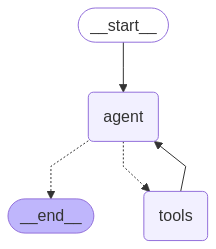

In [9]:
from IPython.display import Image, display

display(Image(flight_agent.get_graph().draw_mermaid_png()))



**Probando el Agente de Vuelos**  

Pongamos a prueba el agente de vuelos con una consulta de ejemplo.

In [10]:
config = {"configurable": {"thread_id": "127", "user_id":578}}
ret_messages = flight_agent.invoke({"messages": [("user", "Encontrar vuelo a Ámsterdam")]}, config)
ret_messages['messages'][-1].pretty_print()

#- Un comentario si quieres ver toda la orquestación, incluyendo la llamada a la herramienta
#ret_messages


================================== Ai Message ==================================

He encontrado varios vuelos disponibles a Ámsterdam para usted:

1. Vuelo 1:
   - Aerolínea: TransContinental
   - Salida: 02:00
   - Llegada: 02:02
   - Duración: 2 minutos
   - Precio: 226

2. Vuelo 2:
   - Aerolínea: SkyWings
   - Salida: 17:44
   - Llegada: 17:46
   - Duración: 2 minutos
   - Precio: 139

3. Vuelo 3:
   - Aerolínea: TransContinental
   - Salida: 15:38
   - Llegada: 15:40
   - Duración: 2 minutos
   - Precio: 254

4. Vuelo 4:
   - Aerolínea: SkyWings
   - Salida: 09:07
   - Llegada: 09:09
   - Duración: 2 minutos
   - Precio: 293

Todos los vuelos son desde Nice y tienen una fecha programada para el 9 de mayo de 2025. El vuelo más económico es el Vuelo 2 de SkyWings, con un precio de 139.

¿Le gustaría más información sobre alguno de estos vuelos o desea hacer una reserva?



### Agente de Hotel
Al igual que con el agente de vuelos, necesitamos crear algunas herramientas que puedan gestionar las reservas de hoteles. Usaremos el mismo enfoque que con los agentes de vuelos.

El Agente de Hotel será responsable de manejar varias tareas relacionadas con hoteles, que incluyen:

- Sugerir hoteles en función de la ciudad y la fecha de entrada
- Recuperar detalles de la reserva de hotel
- Modificar reservas de hotel existentes
- Cancelar reservas de hotel

Estas funcionalidades se implementarán como herramientas separadas, de manera similar al Agente de Vuelos. El Agente de Hotel utilizará estas herramientas para interactuar con un sistema simulado de reservas de hotel.

### Herramienta de sugerencia de hoteles
La función `suggest_hotels` es una herramienta diseñada para sugerir hoteles en función de la ciudad y la fecha de entrada. Toma como entrada el nombre de la ciudad (por ejemplo, "Nueva York") y la fecha de entrada (por ejemplo, "2019-08-30") y devuelve una lista de nombres de hoteles sugeridos.

**Propósito:** Esta herramienta simula un sistema de reservas de hoteles que sugiere hoteles en función de la ciudad y la fecha de entrada.

**Nota:** Esta función está diseñada para fines de demostración y pruebas, utilizando datos generados aleatoriamente en lugar de información real de un sistema de reservas de hoteles.

In [11]:
@tool
def suggest_hotels(city: str, checkin_date: str) -> dict:
    """
    Usa esta herramienta para buscar hoteles en estas ciudades

    Args:
        city (str): El nombre de la ciudad para buscar hoteles
        checkin_date (str): La fecha de entrada en formato AAAA-MM-DD

    Returns:
        dict: Un diccionario que contiene:
            - hotels (list): Lista de nombres de hoteles en la ciudad especificada
            - checkin_date (str): La fecha de entrada proporcionada
            - checkout_date (str): Una fecha de salida generada aleatoriamente
            - price (int): Un precio generado aleatoriamente para la estancia
    """
    hotels = {
        "New York": ["Hotel A", "Hotel B", "Hotel C"],
        "Paris": ["Hotel D", "Hotel E", "Hotel F"],
        "Tokyo": ["Hotel G", "Hotel H", "Hotel I"],
    }

    # Generar fecha de salida aleatoria y precio
    checkin = datetime.strptime(checkin_date, "%Y-%m-%d")
    checkout = checkin + timedelta(days=random.randint(1, 10))
    price = random.randint(100, 500)

    hotel_list = hotels.get(city, ["No se encontraron hoteles"])
    return {
        "hotels": hotel_list,
        "checkin_date": checkin_date,
        "checkout_date": checkout.strftime("%Y-%m-%d"),
        "price": price,
    }



**Herramienta de Recuperación de Reserva de Hotel**  

La función `retrieve_hotel_booking` es una herramienta diseñada para obtener la información de la reserva de hotel desde una base de datos.

**Propósito**: Esta herramienta recupera los detalles de la reserva del hotel basándose en un ID de reserva proporcionado.

**Nota**: Esta función está diseñada para trabajar con un esquema de base de datos específico, suponiendo que existe una tabla llamada `hotel_bookings` con `booking_id` como campo.

In [12]:
@tool
def retrieve_hotel_booking(booking_id: int) -> str:
    """
    Recuperar una reserva de hotel por ID

    Args:
        booking_id (int): El identificador único de la reserva de hotel a recuperar

    Returns:
        str: Una cadena que contiene la información de la reserva del hotel si se encuentra, o un mensaje indicando que no se encontró ninguna reserva
    """
    # conn = sqlite3.connect("data/travel_bookings.db")
    # cursor = conn.cursor()
    booking = ""
    with closing(sqlite3.connect("./data/travel_bookings.db", timeout=10.0)) as conn:
        with closing(conn.cursor()) as cursor:
            cursor.execute(f"SELECT * FROM hotel_bookings WHERE booking_id='{booking_id}'")
            booking = cursor.fetchone()
    
        # Cerrar la conexión
        conn.close()

    if booking:
        return f"Reserva encontrada: {booking}"
    else:
        return f"No se encontró ninguna reserva con el ID: {booking_id}"



**Herramienta de Cambio de Reserva de Hotel** 

La función `change_hotel_booking` es una herramienta diseñada para cambiar la información de la reserva de hotel en la base de datos.

**Propósito:** Esta función permite cambiar las nuevas fechas de check-in y check-out para una reserva existente en la base de datos.

**Nota:** Esta función asume que existe una tabla `hotel_bookings` con las columnas `booking_id` y `check_in_date`.


In [13]:
from datetime import datetime

@tool
def change_hotel_booking(booking_id: int, new_checkin_date: str = None, new_checkout_date: str = None) -> str:
    """
    Cambiar las fechas de una reserva de hotel en la base de datos. Si la tarea se completa, responder con "FINALIZADO"

    Args:
    booking_id (int): El identificador único de la reserva que se va a cambiar
    new_checkin_date (str, opcional): La nueva fecha de check-in en formato YYYY-MM-DD
    new_checkout_date (str, opcional): La nueva fecha de check-out en formato YYYY-MM-DD

    Returns:
    str: Un mensaje que indica el resultado de la operación de cambio de reserva
    """

    # conn = sqlite3.connect("data/travel_bookings.db")  # Reemplazar con el archivo de base de datos real
    # cursor = conn.cursor()

    with closing(sqlite3.connect("./data/travel_bookings.db", timeout=10.0)) as conn:
        with closing(conn.cursor()) as cursor:
            try:
                # Primero, obtener los detalles actuales de la reserva
                cursor.execute(
                    """
                    SELECT * FROM hotel_bookings WHERE booking_id = ?
                """,
                    (booking_id,),
                )
        
                booking = cursor.fetchone()
        
                if booking is None:
                    return f"No se encontró una reserva de hotel con el ID: {booking_id}"
        
                # Desempaquetar los detalles de la reserva
                ( _, user_id, user_name, city, hotel_name, check_in_date, check_out_date, nights, price_per_night, total_price, num_guests, room_type,) = booking
        
                # Actualizar las fechas de check-in y check-out si se proporcionan
                if new_checkin_date:
                    check_in_date = new_checkin_date
                if new_checkout_date:
                    check_out_date = new_checkout_date
        
                # Recalcular noches y precio total
                checkin = datetime.strptime(check_in_date, "%Y-%m-%d")
                checkout = datetime.strptime(check_out_date, "%Y-%m-%d")
                nights = (checkout - checkin).days
                total_price = nights * price_per_night
        
                # Actualizar la reserva en la base de datos
                cursor.execute(
                    """
                    UPDATE hotel_bookings
                    SET check_in_date = ?, check_out_date = ?, nights = ?, total_price = ?
                    WHERE booking_id = ?
                """,
                    (check_in_date, check_out_date, nights, total_price, booking_id),
                )
        
                conn.commit()
        
                return f"Reserva de hotel actualizada: ID de reserva {booking_id}, Nuevo check-in: {check_in_date}, Nuevo check-out: {check_out_date}, Noches: {nights}, Precio total: {total_price} FINALIZADO"
        
            except sqlite3.Error as e:
                conn.rollback()
                return f"Ocurrió un error: {str(e)} ID de reserva {booking_id}, Nuevo check-in: {check_in_date} FINALIZADO"
        
            finally:
                conn.close()


**Herramienta de cancelación de reserva de hotel**
    
La función `cancel_hotel_booking` es una herramienta diseñada para cancelar reservas de hotel en la base de datos.

**Propósito**: Esta función está diseñada para cancelar una reserva de hotel existente en el sistema.



In [14]:
@tool
def cancel_hotel_booking(booking_id: int) -> str:
    """
    Cancelar una reserva de hotel. Si la tarea se completa, responder con "FINALIZADO"

    Argumentos:
        booking_id (int): El identificador único de la reserva que se desea cancelar

    Retornos:
        str: Un mensaje indicando el resultado de la operación de cancelación de la reserva
    """
    # conn = sqlite3.connect("data/travel_bookings.db")
    # cursor  = conn.cursor()
    result=""
    with closing(sqlite3.connect("data/travel_bookings.db", timeout=10.0)) as conn:
        with closing(conn.cursor()) as cursor:
            cursor.execute("DELETE FROM hotel_bookings WHERE booking_id = ?", (booking_id,))
            conn.commit()
        
            # Comprobar si la reserva fue eliminada
            if cursor.rowcount > 0:
                result = f"Reserva cancelada con ID: {booking_id} FINALIZADO"
            else:
                result = f"No se encontró ninguna reserva con ID: {booking_id} FINALIZADO"
        
        # Cerrar la conexión
        conn.close()

    return result
